DATA CAN BE FOUND FROM https://www.kaggle.com/datasets/charunisa/chatgpt-sentiment-analysis

In [1]:
!pip install unidecode

In [2]:
# Load the libraries
import torch
import torch.nn as nn
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.parallel import DistributedDataParallel as DDP

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Set seed for the project
seed = 42
torch.manual_seed(seed)

**READING DATASET**

In [4]:
# Read the dataset
data_path = '/kaggle/input/chatgpt-sentiment-analysis/file.csv'
headers = ['tweets', 'labels']
df = pd.read_csv(data_path, names = headers, encoding='ISO-8859-1')
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,tweets,labels
NaN,tweets,labels
0.0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1.0,"Try talking with ChatGPT, our new AI system wh...",good
2.0,ChatGPT: Optimizing Language Models for Dialog...,neutral
3.0,"THRILLED to share that ChatGPT, our new model ...",good


In [5]:
# Convert the Sentiment to numerical variable
classes = {
    class_name: idx for idx, class_name in enumerate(df['labels'].unique().tolist())
}
df['labels'] = df['labels'].apply(lambda x: classes[x])
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,tweets,labels
NaN,tweets,0
0.0,ChatGPT: Optimizing Language Models for Dialog...,1
1.0,"Try talking with ChatGPT, our new AI system wh...",2
2.0,ChatGPT: Optimizing Language Models for Dialog...,1
3.0,"THRILLED to share that ChatGPT, our new model ...",2


**DATA PREPROCESSING**

In [6]:
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
    # Lowering the text
    text = text.lower()
    
    # Unicode
    text = unidecode.unidecode(text)

    # Remove white space
    text = text.strip()

    # Remove redundants
    text = re.sub(r'[^\w\s]', '', text)

    # Remove stopwords
    text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])

    # Bring the words to their originals
    text = ' '.join([stemmer.stem(word) for word in text.split(' ')])

    return text

In [7]:
df['tweets'] = df['tweets'].apply(lambda x: text_normalize(x))

In [8]:
# Sample
vocab = set()
for sentence in df['tweets'].tolist():
    tokens = sentence.split()
    vocab.update(tokens)

vocab = list(vocab)
vocab.append('UNK')
vocab.append('PAD')
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

In [9]:
def transform(text, word_to_idx, max_seq_len):
    tokens = []
    for w in text.split():
        try:
            w_ids = word_to_idx[w]
        except:
            w_ids = word_to_idx['UNK']
        tokens.append(w_ids)

    # If length of tokens smaller than max_seq_len, add padding. 
    # Otherwise, keep its length as max_seq_len 
    if len(tokens) < max_seq_len:
        tokens += [word_to_idx['PAD']] * (max_seq_len - len(tokens))
    elif len(tokens) > max_seq_len:
        tokens = tokens[:max_seq_len]

    return tokens

In [10]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['tweets'].tolist()
labels = df['labels'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

**PYTORCH DATASET**

In [11]:
class SocialMedia(Dataset):
    def __init__(
        self,
        X, y,
        word_to_idx,
        max_seq_len,
        transform=None
    ):
        self.texts = X
        self.labels = y
        self.word_to_idx = word_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        if self.transform:
            text = self.transform(
                text,
                self.word_to_idx,
                self.max_seq_len
            )
        text = torch.tensor(text)

        return text, label

In [12]:
max_seq_len = 32

# Train dataset
train_dataset = SocialMedia(
    X_train, y_train,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

# Val dataset
val_dataset = SocialMedia(
    X_val, y_val,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

# Test dataset
test_dataset = SocialMedia(
    X_test, y_test,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

In [13]:
train_batch_size = 128
test_batch_size = 8

# Train loader
train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

# Val loader
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

# Test loader
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

**MODEL**

In [14]:
class SentimentClassifier(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim,
        hidden_size, n_layers, n_classes,
        dropout_prob
    ):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Bi-Directional LSEM
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, n_layers,
            batch_first=True, bidirectional = True
        )
        # Initialize LayerNorm with 2 * hidden_size as LSTM is 2 directions
        self.norm = nn.LayerNorm(hidden_size * 2)
        self.dropout = nn.Dropout(dropout_prob)
        
        self.fc1 = nn.Linear(hidden_size * 2, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [15]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model
model = SentimentClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=dropout_prob
).to(device)

# We utilize both GPU T4
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPU!")
    model = nn.DataParallel(model)

Using 2 GPU!


In [16]:
model.eval()

dummy_tensor = torch.randint(10, (1, 10)).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([1, 4])


**TRAINING**

In [17]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [18]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

In [19]:
lr = 1e-4
epochs = 20

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)

In [20]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 1.0254	Val loss: 0.9786
EPOCH 2:	Train loss: 0.9513	Val loss: 0.8669
EPOCH 3:	Train loss: 0.8012	Val loss: 0.7416
EPOCH 4:	Train loss: 0.7093	Val loss: 0.6901
EPOCH 5:	Train loss: 0.6533	Val loss: 0.6498
EPOCH 6:	Train loss: 0.6095	Val loss: 0.6201
EPOCH 7:	Train loss: 0.5764	Val loss: 0.6011
EPOCH 8:	Train loss: 0.5494	Val loss: 0.5934
EPOCH 9:	Train loss: 0.5217	Val loss: 0.5789
EPOCH 10:	Train loss: 0.5001	Val loss: 0.5649
EPOCH 11:	Train loss: 0.4784	Val loss: 0.5519
EPOCH 12:	Train loss: 0.4608	Val loss: 0.5531
EPOCH 13:	Train loss: 0.4437	Val loss: 0.5430
EPOCH 14:	Train loss: 0.4259	Val loss: 0.5486
EPOCH 15:	Train loss: 0.4125	Val loss: 0.5426
EPOCH 16:	Train loss: 0.3979	Val loss: 0.5436
EPOCH 17:	Train loss: 0.3827	Val loss: 0.5417
EPOCH 18:	Train loss: 0.3703	Val loss: 0.5360
EPOCH 19:	Train loss: 0.3573	Val loss: 0.5517
EPOCH 20:	Train loss: 0.3432	Val loss: 0.5566


**PLOTTING LOSSES**

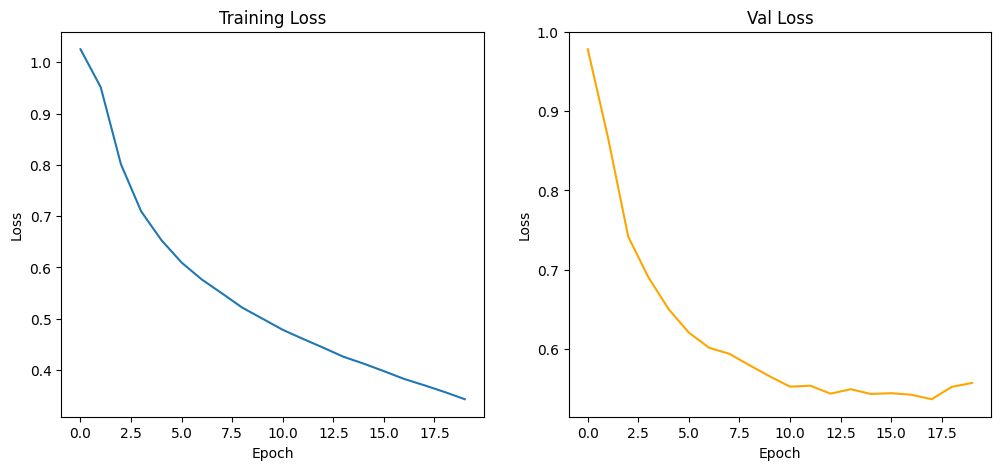

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

**EVALUATION**

In [22]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.7992430287968262
Test accuracy:  0.8042407660738714
